# Processamento Digital de Imagens
## Replicação do trabalho original - In Defense of Classical Image Processing: Fast Depth Completion on the CPU

Alunos:
* Lucas Mendes Massa
* Jhonnye Gabriel de Oliveira Farias

## Requirements

- matplotlib
- numpy
- opencv-python
- pypng

In [31]:
import collections
import cv2
import numpy as np
import glob
import os
import sys
import time
import png
import matplotlib.pyplot as plt
import tqdm

O algoritmo proposto é dividido em 8 passos:
- Depth Inversion
- Custom Kernel Dilation
- Small Hole Closure
- Small Hole Fill
- Extension to Top of Frame
- Large Hole Fill
- Median and Gaussian Blur
- Depth Inversion

## Definindo kernels a serem usados

In [2]:
# Full kernels
FULL_KERNEL_3 = np.ones((3, 3), np.uint8)
FULL_KERNEL_5 = np.ones((5, 5), np.uint8)
FULL_KERNEL_7 = np.ones((7, 7), np.uint8)
FULL_KERNEL_9 = np.ones((9, 9), np.uint8)
FULL_KERNEL_31 = np.ones((31, 31), np.uint8)

# 3x3 cross kernel
CROSS_KERNEL_3 = np.asarray(
    [
        [0, 1, 0],
        [1, 1, 1],
        [0, 1, 0],
    ], dtype=np.uint8)

# 5x5 cross kernel
CROSS_KERNEL_5 = np.asarray(
    [
        [0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0],
        [1, 1, 1, 1, 1],
        [0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0],
    ], dtype=np.uint8)

# 5x5 diamond kernel
DIAMOND_KERNEL_5 = np.array(
    [
        [0, 0, 1, 0, 0],
        [0, 1, 1, 1, 0],
        [1, 1, 1, 1, 1],
        [0, 1, 1, 1, 0],
        [0, 0, 1, 0, 0],
    ], dtype=np.uint8)

# 7x7 cross kernel
CROSS_KERNEL_7 = np.asarray(
    [
        [0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0],
    ], dtype=np.uint8)

# 7x7 diamond kernel
DIAMOND_KERNEL_7 = np.asarray(
    [
        [0, 0, 0, 1, 0, 0, 0],
        [0, 0, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0],
        [0, 0, 1, 1, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0],
    ], dtype=np.uint8)

## Implementando os passos do algoritmo

### Depth inversion

In [3]:
def depth_inversion(depth_map, max_depth):
    valid_pixels = (depth_map > 0.1)
    depth_map[valid_pixels] = max_depth - depth_map[valid_pixels]
    return depth_map

### Custom Kernel Dilatation

In [4]:
def custom_kernel_dilatation(depth_map, custom_kernel):
    depth_map = cv2.dilate(depth_map, custom_kernel)
    return depth_map

### Small Hole Closure


In [5]:
def small_hole_closure(depth_map, kernel):
    depth_map = cv2.morphologyEx(depth_map, cv2.MORPH_CLOSE, kernel)
    return depth_map

### Small Hole Fill


In [6]:
def small_hole_fill(depth_map, kernel):
    empty_pixels = (depth_map < 0.1)
    dilated = cv2.dilate(depth_map, kernel)
    depth_map[empty_pixels] = dilated[empty_pixels]
    return depth_map

### Extension to Top of Frame

In [7]:
def extension_to_top_of_frame(depth_map):
    top_row_pixels = np.argmax(depth_map > 0.1, axis=0)
    top_pixel_values = depth_map[top_row_pixels, range(depth_map.shape[1])]

    for pixel_col_idx in range(depth_map.shape[1]):
        depth_map[0:top_row_pixels[pixel_col_idx], pixel_col_idx] = \
            top_pixel_values[pixel_col_idx]
    
    return depth_map

### Large Hole Fill

In [8]:
def large_hole_fill(depth_map, kernel):
    empty_pixels = depth_map < 0.1
    dilated = cv2.dilate(depth_map, FULL_KERNEL_31)
    depth_map[empty_pixels] = dilated[empty_pixels]
    
    return depth_map

### Median and Gaussian Blur

In [9]:
def median_and_gaussian_blur(depth_map, blur_type):
    # Median blur
    depth_map = cv2.medianBlur(depth_map, 5)

    # Bilateral or Gaussian blur
    if blur_type == 'bilateral':
        # Bilateral blur
        depth_map = cv2.bilateralFilter(depth_map, 5, 1.5, 2.0)
    elif blur_type == 'gaussian':
        # Gaussian blur
        valid_pixels = (depth_map > 0.1)
        blurred = cv2.GaussianBlur(depth_map, (5, 5), 0)
        depth_map[valid_pixels] = blurred[valid_pixels]
        
    return depth_map

## Criando a função de depth completion fazendo uso dos passos acima

In [10]:
def depth_completion(depth_map, max_depth, custom_kernels, extrapolate, blur_type):
    
    # invertion
    depth_map = depth_inversion(depth_map, max_depth)
    
    # dilatation
    depth_map = custom_kernel_dilatation(depth_map, custom_kernels['dilatation'])
    
    # small hole closure
    depth_map = small_hole_closure(depth_map, custom_kernels['closure'])
    
    # small hole filling 
    depth_map = small_hole_fill(depth_map, custom_kernels['small_fill'])
    
    if extrapolate:
        # extension to top
        depth_map = extension_to_top_of_frame(depth_map)        
        # large hole filling
        depth_map = large_hole_fill(depth_map, custom_kernels['large_fill'])
        
    # median and gaussian blur
    depth_map = median_and_gaussian_blur(depth_map, blur_type)
    
    # invertion
    depth_map = depth_inversion(depth_map, max_depth)
    
    return depth_map

## Definindo valores padrão a serem usados de acordo com o paper

In [11]:
custom_kernels={
    'dilatation': DIAMOND_KERNEL_5,
    'closure': FULL_KERNEL_5,
    'small_fill': FULL_KERNEL_7,
    'large_fill': FULL_KERNEL_31,
}
max_depth = 100.0
extrapolate = True
blur_type = 'gaussian'

## Aplicando o algoritmo

In [12]:
# alterar o path para o da pasta no respectivo computador
inputs_path = os.path.join('dataset','val_selection_cropped','velodyne_raw')
groundtruth_path = os.path.join('dataset','val_selection_cropped','groundtruth_depth')
images_path = os.path.join('dataset','val_selection_cropped','image')

In [13]:
img_names = glob.glob(os.path.join(images_path, '*.png'))
img_names = [os.path.split(p)[-1] for p in img_names]

### Imagens a serem utilizadas

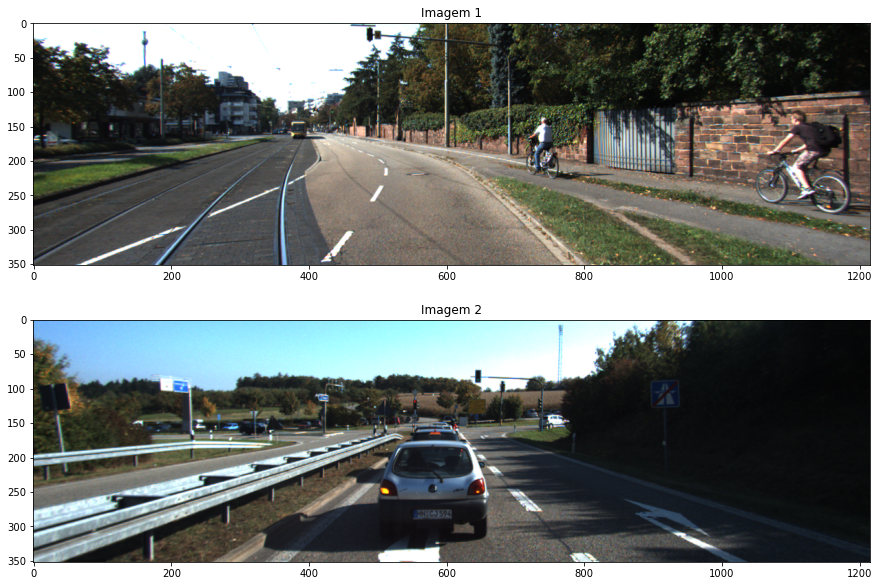

In [14]:
name1 = img_names[0]
name2 = img_names[-1]

img1 = cv2.imread(os.path.join(images_path,name1))
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.imread(os.path.join(images_path,name2))
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

fig = plt.figure(figsize=(15, 10))
rows = 2
columns = 1
  
fig.add_subplot(rows, columns, 1)
plt.title('Imagem 1')
plt.imshow(img1)

fig.add_subplot(rows, columns, 2)
plt.title('Imagem 2')
plt.imshow(img2)

### Aplicando na imagem 1

In [15]:
depth_image = cv2.imread(os.path.join(inputs_path,name1.replace('sync_image', 'sync_velodyne_raw')), cv2.IMREAD_ANYDEPTH)
map1 = np.float32(depth_image / 256.0)

In [16]:
result1 = depth_completion(map1, max_depth, custom_kernels, extrapolate, blur_type)

In [17]:
depth_image = cv2.imread(os.path.join(groundtruth_path,name1.replace('sync_image', 'sync_groundtruth_depth')), cv2.IMREAD_ANYDEPTH)
groundtruth1 = np.float32(depth_image / 256.0)

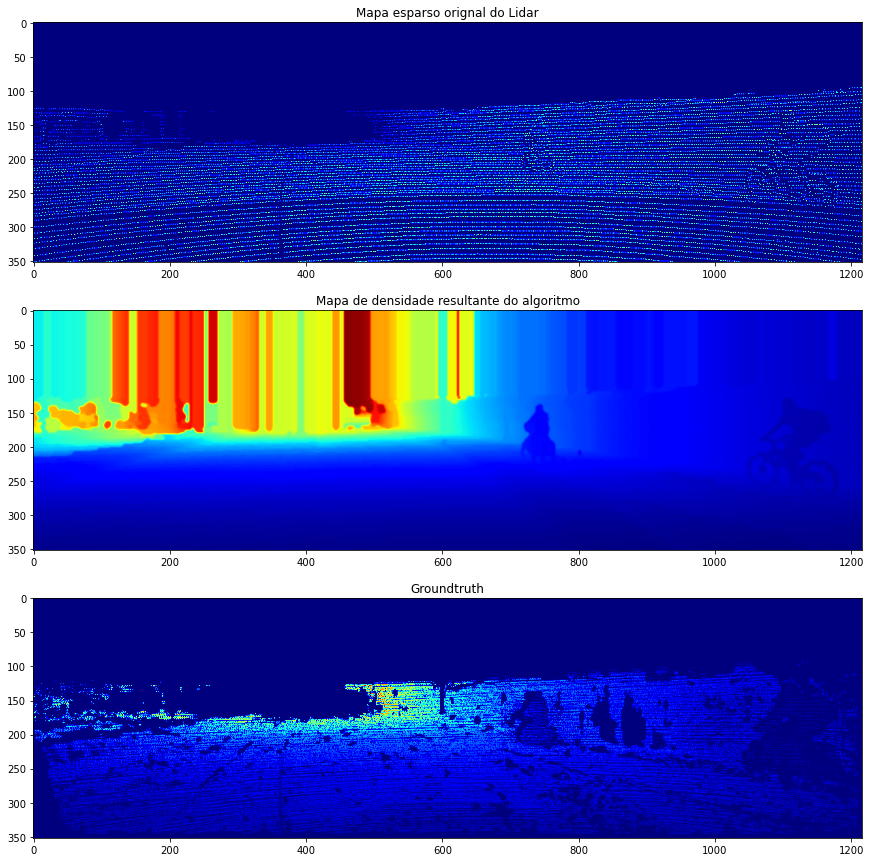

In [18]:
fig = plt.figure(figsize=(15, 15))
rows = 3
columns = 1
  
fig.add_subplot(rows, columns, 1)
plt.title('Mapa esparso orignal do Lidar')
plt.imshow(map1, cmap='jet')

fig.add_subplot(rows, columns, 2)
plt.title('Mapa de densidade resultante do algoritmo')
plt.imshow(result1, cmap='jet')

fig.add_subplot(rows, columns, 3)
plt.title('Groundtruth')
plt.imshow(groundtruth1, cmap='jet')

### Aplicando na imagem 2

In [19]:
depth_image = cv2.imread(os.path.join(inputs_path,name2.replace('sync_image', 'sync_velodyne_raw')), cv2.IMREAD_ANYDEPTH)
map2 = np.float32(depth_image / 256.0)

In [20]:
result2 = depth_completion(map2, max_depth, custom_kernels, extrapolate, blur_type)

In [21]:
depth_image = cv2.imread(os.path.join(groundtruth_path,name2.replace('sync_image', 'sync_groundtruth_depth')), cv2.IMREAD_ANYDEPTH)
groundtruth2 = np.float32(depth_image / 256.0)

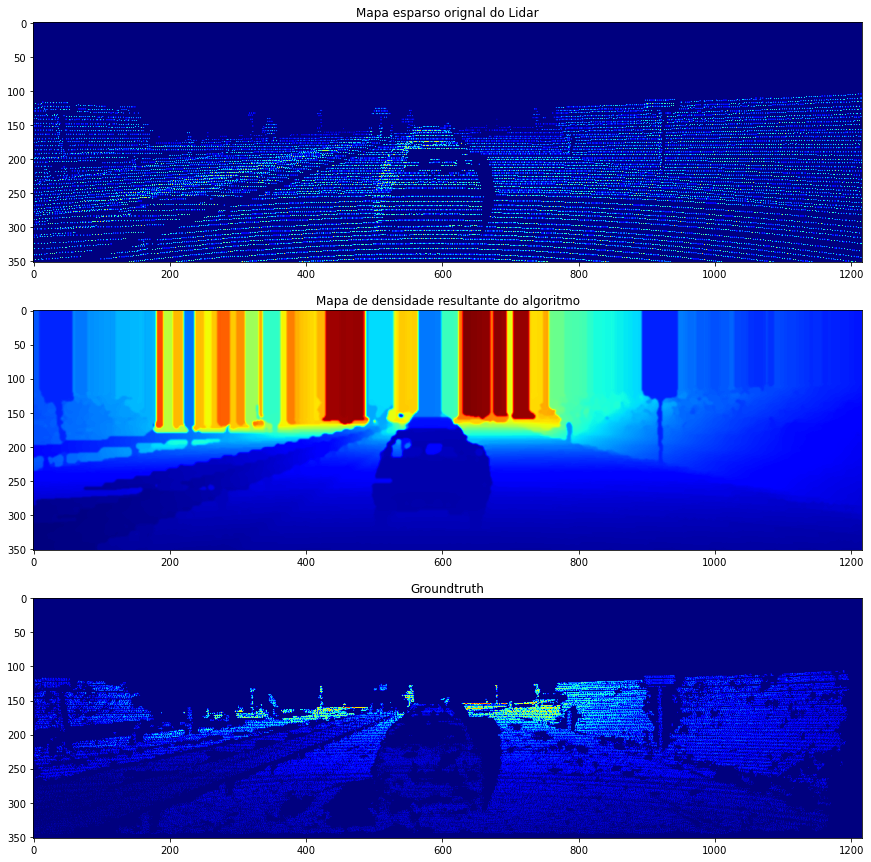

In [22]:
fig = plt.figure(figsize=(15, 15))
rows = 3
columns = 1
  
fig.add_subplot(rows, columns, 1)
plt.title('Mapa esparso orignal do Lidar')
plt.imshow(map2, cmap='jet')

fig.add_subplot(rows, columns, 2)
plt.title('Mapa de densidade resultante do algoritmo')
plt.imshow(result2, cmap='jet')

fig.add_subplot(rows, columns, 3)
plt.title('Groundtruth')
plt.imshow(groundtruth2, cmap='jet')

## Comparando com os resultados do paper

In [42]:
def calculate_performace(img_names, max_depth, custom_kernels, extrapolate, blur_type):
    results = {}
    times = 0
    MAE = 0
    RMSE = 0    
    count = 0
    
    for name in tqdm.tqdm(img_names):
        depth_image = cv2.imread(os.path.join(inputs_path,name.replace('sync_image', 'sync_velodyne_raw')), cv2.IMREAD_ANYDEPTH)
        depth_map = np.float32(depth_image / 256.0)
        
        # calculate execution time
        init = time.perf_counter()
        result = depth_completion(depth_map, max_depth, custom_kernels, extrapolate, blur_type)
        times += time.perf_counter() - init
        
        depth_image = cv2.imread(os.path.join(groundtruth_path,name.replace('sync_image', 'sync_groundtruth_depth')), cv2.IMREAD_ANYDEPTH)
        groundtruth = np.float32(depth_image / 256.0)
        
        result = result.reshape(result.shape[0]*result.shape[1])
        groundtruth = groundtruth.reshape(groundtruth.shape[0]*groundtruth.shape[1])
        
        valid_idx = groundtruth>0.1
        result = result[valid_idx]
        groundtruth = groundtruth[valid_idx]
        
        # account for MAE
        MAE += np.mean(np.abs(result - groundtruth))
        
        # account for RMSE
        RMSE += np.sqrt(np.mean(np.square(result - groundtruth)))
        
        count += 1
        
    results['time'] = times/count
    results['MAE'] = MAE/count
    results['RMSE'] = RMSE/count
    
    return results

In [43]:
performance = calculate_performace(img_names, max_depth, custom_kernels, extrapolate, blur_type)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:21<00:00, 46.88it/s]


In [44]:
performance

{'time': 0.010867140799995468,
 'MAE': 0.30492323108017444,
 'RMSE': 1.3453351870179175}

## Conclusão

Os resultados acima se aproximam dos mostrados no paper. Dessa forma, pode-se considerar que a replicação aqui realizada é válida.